In [1]:
import cv2
import numpy as np
from scipy.signal import convolve2d
from scipy.sparse.linalg import bicg
from scipy.optimize import fmin_cg
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys
from tqdm import tqdm_notebook as tqdm
import sklearn
import sklearn.neighbors as neighbors
# from sklearn.neighbors import LSHForest

In [2]:
with Notebook(): 
        import utils
        import pinkNoise
        import reblur

## patch recurence

image ./resources/test4.png loaded
(300, 438)


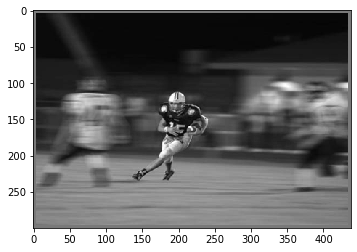

In [3]:
img = utils.loadImage('./resources/test4.png', 'gray')
# x, K = utils.nonUniformBlur(img)
x = img
print(x.shape)
plt.imshow(x, cmap='gray')

In [4]:
def downscale(x, alpha, show=False):
    '''
     @input: blurred img x
     @input: estimated kernel k

     @return: deblurred image
    '''


    downscaled_image = cv2.resize(x,None, fx=1/alpha,fy=1/alpha,interpolation=cv2.INTER_LANCZOS4)
    
    if show:
        plt.imshow(downscaled_image, cmap='gray')
        plt.figure()
        plt.imshow(x, cmap='gray')
        plt.show()
        downscaled_image.shape, x.shape
    
    return downscaled_image

In [6]:
from annoy import AnnoyIndex

class AnnoyKNN:
    def __init__(self, img, patch_size):
        self.image = img
        self.patch_size = patch_size
        self.feature_dims = patch_size*patch_size
        self.KNN = None
    
    def make_index(self, method):
        """
            make indices to be used for search in KNN
            patches are flatten and treated as 1D vectors
        """
        self.KNN = AnnoyIndex(self.feature_dims, method)
        img = utils.im2col(self.image, [self.patch_size, self.patch_size])
        for i in range(img.shape[1]):
            self.KNN.add_item(i, (img.T)[i,:])
            
    def build(self, n_trees):
        """
            specify the no. of trees to be used
            more trees -> higher accuracy, higher search time
        """
        self.KNN.build(n_trees)
        
    def get_nn(self, patch):
        """
            input patch to be searched
            returns the nearest patch from indices
        """
        nn = self.KNN.get_nns_by_vector(patch.flatten(), 1)
        nn = self.KNN.get_item_vector(nn[0])
        return (np.array(nn)).reshape((self.patch_size, self.patch_size))

In [7]:
"""
imrpove -> predict for the entire row at once, using njobs
intra image reccurence
"""

from annoy import AnnoyIndex
import random
import time


def getPriorPatch(patch, im_shape, cimg, h):
    k = patch.shape[0]
    
    num = np.zeros((k,k))
    denom = 0
    
    cpatch = patch.ravel()[:,None]
    
    prob = np.exp(-np.mean((cpatch - cimg)**2, axis=0)/(2*(h**2)))
    denom = np.sum(prob)
    num = cimg @ prob[:,None]
    num = num.reshape((k,k))
    
#     for i in range(k//2+1, n-k//2):
#         for j in range(k//2+1, m-k//2):
#             splice = img[i-k//2:i+k//2+1, j-k//2:j+k//2+1]
#             err = np.mean((patch - splice)**2)
#             exp = -err/(2*(h**2))
            
#             p = np.exp(exp)
#             num += p * splice
#             denom += p
            
    return num/(denom*k*k)

def getPrior(img, patch_size, alpha, h, stride):
    """
    @input img: size (n x m)
    @input patch_size
    @input alpha
    @input h
    @input stride: not used
    
    @return z: size (n x m)
    """
    
    start = time.time()
    M = patch_size
    x_alpha = downscale(img, alpha)
    n,m = img.shape
    
    KNN = AnnoyKNN(x_alpha, M)
    KNN.make_index('euclidean')
    KNN.build(200)
    

    # build NN model
#     cx_alpha = utils.im2col(x_alpha, [M,M])
#     model = neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='auto', n_jobs=-1)
#     model.fit(cx_alpha.T, np.arange(cx_alpha.shape[1]))
    
    z = np.zeros(img.shape)
    
#     cimg = utils.im2col(img, [M,M])
#     predictions = cx_alpha[:, model.predict(cimg.T)]
    
    for i in tqdm(range(M//2, n-M//2)):
        for j in range(M//2, m-M//2):
#             prior = predictions[:, (i-M//2)*(m-2*(M//2)) + (j-M//2)].reshape((M,M))/(M*M)
#             prior = getPriorPatch(patch, x_alpha.shape, cimg, h)
            z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += KNN.get_nn(img[i-M//2:i+M//2+1, j-M//2:j+M//2+1])/(M*M)
#             z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += (np.array(prior)).reshape((M,M))/(M*M)
    
    end = time.time()
    print('time taken:', end-start)
    
    return z

In [8]:
z = getPrior(x, 21, 4/3, 10, 1)

/home/sankalp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



time taken: 58.83598709106445


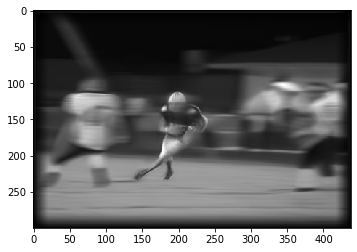

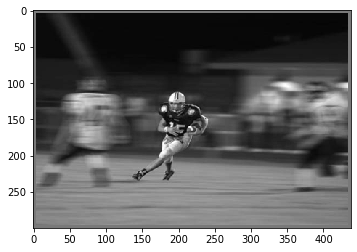

In [9]:
plt.imshow(z, cmap='gray')
plt.show()
plt.imshow(x, cmap='gray')

In [ ]:
k = 1/25*np.ones((5,5))
cv2.filter2D(x,-1, k)
plt.imshow(cv2.filter2D(x, -1, 1/25*np.ones((11,11))), cmap='gray')

In [111]:
def func(x, *args):
    global ct_func
    K, b, beta, lam, ss = args
    xx = np.reshape(x, ss)
    tt = convolve2d(xx, K, 'same')
    tt = tt[K.shape[0]//2:-K.shape[0]//2+1, K.shape[1]//2:-K.shape[1]//2+1]
    y = lam*convolve2d(tt, np.rot90(np.rot90(K)), 'full')
    y = y + beta*xx
    y = y.ravel() - b
    y = np.power(y, 2)/2
    print("  Iter -> ", ct_func, end = '\r')
    ct_func+=1
    return np.mean(y)

def costGradient(x, *args):
    K, b, beta, lam, ss = args
    xx = np.reshape(x, ss)
    tt = convolve2d(xx, K, 'same')
    tt = tt[K.shape[0]//2:-K.shape[0]//2+1, K.shape[1]//2:-K.shape[1]//2+1]
    y = lam*convolve2d(tt, np.rot90(np.rot90(K)), 'full')
    y = y + beta*xx
    y = y.ravel() - b
    return np.mean(y)

In [143]:
def EPLLhalfQuadraticSplitDeblur(noiseI, lam, K, patchSize, betas, T, alpha, h, stride):
#     RealNoiseSD = np.sqrt(1/(lam[1]/patchSize^2))
#     if expecting cost
#     calc_cost = False
#     cost = []
    global z
    beta = np.abs(betas[0]/4)
    cleanI = noiseI
#     k=1
#     sd = float('inf')
#     print(betas)
    for betaa in betas:
#         if any beta<0 estimate betas automatically
#         if betaa<0:
#             old_sd = sd
#             sd = estimateNoiseSDUsingKurts(cleanI,12)
# #             fprintf('sd is:%f beta is %f * (1/noiseSD^2)',sd,(1/sd^2)/(1/RealNoiseSD^2))
#             sd = sd
#             if np.isnan(sd) or sd>old_sd:
#                 beta = beta*4
#                 sd = np.power(beta, -0.5)
#             else:
#                 beta = 1/sd**2
#         else:
#             beta = betaa
        beta = betaa
#         print(beta)
        for tt in range(T):
            print("Iteration -> ", tt)
#             Z step
#             Z = utils.im2col(cleanI,[patchSize, patchSize]);

#             calculate orignal cost if LogLFunc is defined and output
#             arguments expect it
#             if calc_cost:
#                 cost[k] = 0.5*lam@np.sum(np.power(cleanI.ravel()- noiseI.ravel(),2)) - EPLL(Z,LogLFunc)
            
            
# ---------------------------------add prior here------------------------------------------------------
#             cleanZ = prior(Z,patchSize,(beta)^-0.5,size(noiseI));

#------------------------------------------------------------------------------------------------------


#             x step
#             print("getting Prior")
            I1 = z
#             I1 = getPrior(cleanI, patchSize, alpha, h, stride)
#             I1, counts = scol2im(cleanZ, patchSize, I.shape[0], I.shape[1], 'sum')
#             print("prior mil gaya")
            tt1 = noiseI[(K.shape[0]//2):-(K.shape[0]//2),(K.shape[1]//2):-(K.shape[1]//2)]
#             convolution with the rotated kernel (LHS of Equation 4 in the
#             paper)
            tt1 = convolve2d(tt1, np.rot90(np.rot90(K)), 'full')
            tt2 = I1
#             Solve for x, using the convolved image from above (Equation 4 in
#             the paper)
            x0 = I1.ravel()
            print("fmin ke andar")
            cleanI = fmin_cg(func, x0, fprime=costGradient, args = (K, lam*tt1.ravel() + beta*tt2.ravel(), beta, lam, I1.shape), maxiter=100)
            cleanI = np.reshape(cleanI, noiseI.shape)
            arr = plt.subplots(1,2, figsize = (15,15))[1]
            arr[0].imshow(I1, cmap='gray')
            arr[1].imshow(cleanI, cmap='gray')
#             cleanI = reshape(bicg(@(x,tflag) Afun(x,K,counts,beta,lam,size(I),tflag),(lam*tt1(:) + beta*tt2(:)),1e-6,2500),size(noiseI));

#             psnr(k) = 20*log10(1/std2(cleanI-I));

#             fprintf('PSNR is:%f I1 PSNR:%f\n',psnr(k),20*log10(1/std2(I1./counts-I)));
#              imshow([I noiseI cleanI],[0 1]); drawnow;
#             k=k+1;
    return cleanI

Iteration ->  0
fmin ke andar
         Current function value: 97228848956878.046875
         Iterations: 1
         Function evaluations: 73
         Gradient evaluations: 61


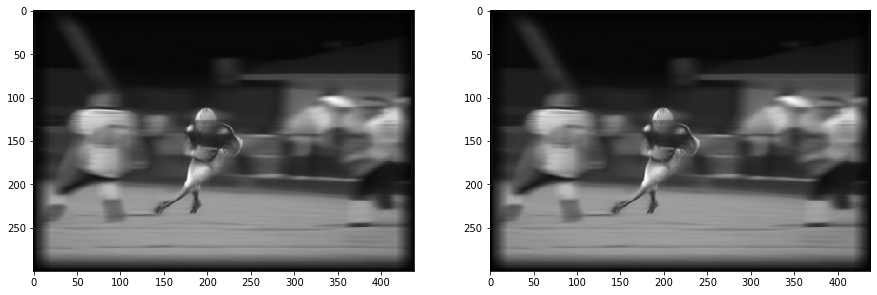

In [144]:
ct_func = 1

noiseSD = 0.01
patchSize = 21
alpha = 4/3
betas = 50*np.array([1])
T = 1
h = 10
stride = 1
K=cv2.getGaussianKernel(5,1)
K = K@K.T
noiseI = np.float32(x)
cleanI = EPLLhalfQuadraticSplitDeblur(noiseI, 64/(noiseSD**2), K, patchSize, betas, T, alpha, h, stride)